In [2]:

from __future__ import division
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import reconv_fit as rcfit
import scipy.optimize as opt
import scipy.interpolate as interp
import lmfit

In [7]:
#Load some TA data from Dallas' sample. 400nm pump shown, X1 pump is there too though.
#Units in dataset are ps,nm and Delta OD. I've changed it to mOD though.

Perovs = np.load('3dTA_data_example_CsPbBr3_NCs.npz')
print(Perovs.keys())
wvl = Perovs['wvl']

time = Perovs['time']
x4 = Perovs['dod1']*1e3
x1 = Perovs['dod2']*1e3

plt.figure()
plt.pcolormesh(wvl,time,x4)
plt.ylim(time[0],time[-1])
plt.colorbar()

['wvl', 'dod2er', 'dod2', 'dod1er', 'dod1', 'time']


## Make $\Delta \Delta$ OD(t) curves at interesting probe energies
## Make resampled weights

<IPython.core.display.Javascript object>


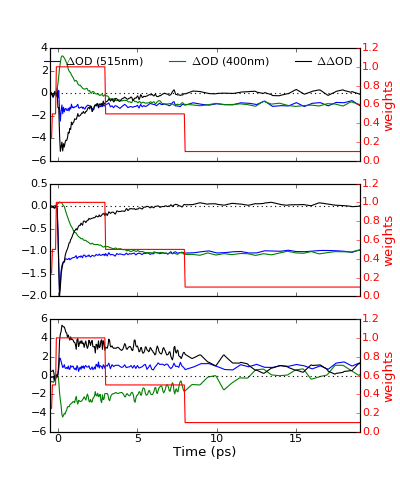

In [19]:
# Take X1 pump and 3eV pump and take difference. This will make the multiexponential curve we want to fit.
# Need to shift relative time zero, then interpolate b/c they no longer match u precisely in time.

def ddod(t,y1,y2,t0,tsamp):
    """
    Linear Interpolate y1 and y2 to get equal regular grids that can be shifted arbitrarily.
    Normalize y1 and y2 so they both go to + or - 1 at tsamp[-1].
    Subtract: ynew =  y1n(t) - y2n(t-t0)
    Inputs
    ------------------------------------
    t - 1D array contains times sampled, could be irregular
    y1 - raw dOD values for pump 1
    y2 - raw dOD values for pump 2
    t0 - difference in time zero b/w pump1 and pump2
    tsamp - New regular grid you want to sample. 
            Should have time steps small enough to make the substraction smooth.
    
    Returns
    --------------------------------------
    y1n, y2n, y1n-y2n - Normalized curves sampled on tsamp.
    """
    f1 = interp.interp1d(t,y1,bounds_error=False,fill_value=(0,y1[-1]))
    f2 = interp.interp1d(t,y2,bounds_error=False,fill_value=(0,y2[-1]))
    t_arg = np.argmin(np.abs(t-tsamp[-1]))
    n1 = np.abs(np.mean(y1[t_arg-2:t_arg+2]))
    n2 = np.abs(np.mean(y2[t_arg-2:t_arg+2]))
    y1new = f1(tsamp)
    y2new = f2(tsamp-t0)
    return y1new/n1, y2new/n2, y1new/n1 - y2new/n2

def nm2eV(x):
    return 6.6266*2.998*100/(1.602*x)

energy = nm2eV(wvl)
probes=[2.35,2.4,2.53]
lbls = ['A1','B1','A2']
ddods = []

tlims = (19.5,19.5,30)
tsamp = np.array([np.arange(-0.5,l,0.05) for l in tlims])
tshift = -0.07

#Weights vector from reconv_fit
#Used to adjust weights and not overfit sparse data
ws = [rcfit.resamp_weights(time,t) for t in tsamp]
c = ['b','g','k']
f,axs = plt.subplots(3,sharex=True,figsize=(5,6))

for i,pr in enumerate(probes):
    elm = np.argmin(np.abs(energy-pr))
    ddods.append(ddod(time,x1[:,elm],x4[:,elm],tshift,tsamp[i]))
    [axs[i].plot(tsamp[i],y,c[j]) for j,y in enumerate(ddods[-1])]
    axs[i].plot([-10,100],[0,0],'k:')
    aright = axs[i].twinx()
    aright.plot(tsamp[i],ws[i],'r')
    aright.set_ylabel('weights',color='r')
    aright.tick_params(axis='y',color='r',labelcolor='r')
axs[0].legend(['$\Delta$OD (515nm)','$\Delta$OD (400nm)','$\Delta \Delta$OD'],ncol=2)
axs[-1].set_xlim(-0.5,19)
axs[-1].set_xlabel('Time (ps)')
axs[1].set_ylabel('$\Delta$ OD')

## Make and fit the model with weights.

In [24]:
mod = lmfit.Model(rcfit.biexp_conv)

def mk_params(y):
    """
    Make parameters for a biexponential decay, convolved with irf, given a curve(x,y).
    Inputs:
        y - 1xN array for data
    Output:
        lmfit.Parameters object.
        a0,tau0,a1,tau1,irf,t0
    """
    params = lmfit.Parameters()
    params.add_many(('irf',0.07,True,0.03,0.2),
                    ('t0',0.0,True,-0.05,0.05))
    a0 = 2*y[np.argmax(np.abs(y))]/3
    a1 = y[np.argmax(np.abs(y))]/3
    
    params.add_many(
            #add with tuples: (NAME, VALUE, VARY, MIN,  MAX,  EXPR,  BRUTE_STEP)
            ('a0', a0, True, -1.5*np.argmax(np.abs(y)), 1.5*np.argmax(np.abs(y)), None, None),
            ('a1', a1, True, -1.5*np.argmax(np.abs(y)), 1.5*np.argmax(np.abs(y)), None, None),
            ('tau0', 1, True, 1e-2, 5, None, None),
            ('tau1',10,True,1,30))
    return params

    
fits = []

print("FITTING...")
for i,y in enumerate(ddods):
    tfit = tsamp[i]
    yfit = y[-1]
    #Notice that I'm passing a weights argument to Model.fit().
    fits.append(mod.fit(data=yfit,t=tfit,params=mk_params(yfit),weights=ws[i]))

FITTING...


In [ ]:
#You have to zoom in a lot on the plots since the errorbars come from the weights passed to Model.fit()
#These errorbars make it hard to see the data.
for f in fits:
    print(f.ci_report())
    f.plot()
    